# Kinetics from TST

## Example for $O + H_2 \rightleftharpoons H + OH$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


import rmgpy.data.kinetics
import rmgpy.reaction
import rmgpy.quantity
import rmgpy.constants

import ase.units
import ase.io.gaussian
import ase.calculators.gaussian

## Transition State Theory Kinetics

$$k_{TST}=\frac{k_BT}{h}\cdot \frac{Q^{TS}}{Q^{IS}}\cdot e^{-\frac{E_a}{k_BT}}$$


The leaves $Q^{TS}$, $Q^{IS}$, and $E_a$ to be calculated


1. Find IS and TS Geometries

### Calculate the Partition Functions

$$Q^{IS}=q_{F}q_{H_2}$$


#### Translation Partition Function
$$q_{trans} = \left(\frac{2 \pi \sum_{atoms, i} m_i k T}{h^2} \right)^{\frac{3}{2}}V = \left(\frac{2 \pi \sum_{atoms, i} m_i k T}{h^2} \right)^{\frac{3}{2}} \frac{NRT}{P}$$

#### Rotation Partition Function
Linear Molecules:
$$q_{rot} = \frac{T}{\sigma \Theta_r} \quad$$

Nonlinear Molecules:
$$q_{rot} = \frac{\sqrt{\pi}}{\sigma} \left( \frac{T^3}{\Theta_A\Theta_B\Theta_C}\right)^{\frac{1}{2}} \quad$$

#### Vibrational Partition Function
$$q_{vib} = e^{-\frac{\frac{1}{2}\sum_i{h\nu_i}}{kT}} \prod_{i=1}^{l} \frac{1}{1-e^{-\Theta_{v,i}/T}}$$


In [2]:
# Load Constants

kb = ase.units._k
MW_H = 1.00784
MW_O = 15.999
MW_OH = MW_O + MW_H
MW_H2 = 2.0 * MW_H
MW_HHO = 2.0 * MW_H + MW_O
N_av = ase.units._Nav
h = ase.units._hplanck
mass_O = MW_O / N_av / 1000.0
mass_H = MW_H / N_av / 1000.0
mass_H2 = MW_H2 / N_av / 1000.0
mass_OH = MW_OH / N_av / 1000.0
mass_HHO = MW_HHO / N_av / 1000.0
volume = 1.0  # m^3
R = 8.31446261815324  # J/mol K

c = 29979245800  # speed of light in cm/s

In [14]:
T = np.linspace(300, 3000, 101)
# T = 300

#### Partition Function of Oxygen Atom

In [15]:
n = 1.0 / N_av  # convert from one molecule to units of mols
P = 101325  # 1 atm for comparison with Guassian results
V = n * R * T / P
qO_trans = np.float_power(2.0 * np.pi * mass_O * kb * T / np.float_power(h, 2.0), 1.5) * V
qO_elec = 3
qO_rot = 1
qO_vib = 1
qO = qO_trans * qO_elec * qO_rot * qO_vib

#### Partition Function of H2

Vib analysis from Gaussian yields 1 freq: 4394.01 cm^-1

In [16]:
# Translation
qH2_trans = np.float_power(2.0 * np.pi * mass_H2 * kb * T / np.float_power(h, 2.0), 1.5) * V

# Rotation
H2_log = "/work/westgroup/harris.se/autoscience/autoscience_workflow/results/dft/thermo/species_0016/arkane/conformer_0000.log"
with open(H2_log, 'r') as f:
    h2_atoms = ase.io.gaussian.read_gaussian_out(f)
I = h2_atoms.get_moments_of_inertia()[-1]
I /= (ase.units.kg * ase.units.m * ase.units.m)  # convert from amu*Angstroms^2 to kg*m^2
rotational_temperature = np.float_power(h, 2.0) / (8.0 * np.pi * np.pi * I * kb)
rotational_symmetry = 2.0
qH2_rot = T / (rotational_symmetry * rotational_temperature)

# Vibration
# vib_freqs_per_cm = np.array([4394.01])  # cm ^ -1
# freq_correction = 0.986  #b3lyp

vib_freqs_per_cm = np.array([4467.0])  # cm ^ -1
freq_correction = 0.982

vib_freqs_per_cm *= freq_correction
vib_freqs = c * vib_freqs_per_cm  # frequencies should be on the order of 10^12
vib_temps = h * vib_freqs / kb  # matches Gaussian log
E_zp = np.exp(-0.5 * h * np.sum(vib_freqs) / (kb * T))

qH2_vib = E_zp
qH2_vib = 1.0
for i in range(0, len(vib_temps)):
    qH2_vib = np.multiply(qH2_vib, 1.0 / (1.0 - np.exp(-vib_temps[i]/T)))


qH2_elec = 1

qH2 = qH2_trans * qH2_elec * qH2_rot * qH2_vib

#### Partition Function of HHO

In [17]:
# Translation
qHHO_trans = np.float_power(2.0 * np.pi * mass_HHO * kb * T / np.float_power(h, 2.0), 1.5) * V

# Rotation
HHO_log = "/work/westgroup/harris.se/autoscience/autoscience_workflow/results/dft/kinetics/backup_reaction_0001/overall/fwd_ts_0000.log"
with open(HHO_log, 'r') as f:
    hho_atoms = ase.io.gaussian.read_gaussian_out(f)
I = hho_atoms.get_moments_of_inertia()
I /= (ase.units.kg * ase.units.m * ase.units.m)  # convert from amu*Angstroms^2 to kg*m^2
rotational_temperatures = np.float_power(h, 2.0) / (8.0 * np.pi * np.pi * I * kb)
rotational_symmetry = 1.0
qHHO_rot = 1.0 / rotational_symmetry * np.sqrt(np.pi * np.float_power(T, 3) / np.prod(rotational_temperatures))
# qHHO_rot = 0.0875
print(qHHO_rot)


# Vibration
vib_freqs_per_cm = np.array([508.8, 1608.91])  # cm ^ -1 
freq_correction = 0.982
vib_freqs_per_cm *= freq_correction
vib_freqs = c * vib_freqs_per_cm  # frequencies should be on the order of 10^12
vib_temps = h * vib_freqs / kb  # matches Gaussian log
print(vib_temps)
E_zp = np.exp(-0.5 * h * np.sum(vib_freqs) / (kb * T))

qHHO_vib = E_zp
qHHO_vib = 1
for i in range(0, len(vib_temps)):
    qHHO_vib = np.multiply(qHHO_vib, 1.0 / (1.0 - np.exp(-vib_temps[i] / T)))


qHHO_elec = 3

qHHO = qHHO_trans * qHHO_elec * qHHO_rot * qHHO_vib

[0.08834687 0.10053816 0.11324373 0.12644357 0.14011981 0.15425639
 0.1688388  0.18385378 0.19928923 0.21513399 0.23137774 0.24801091
 0.26502459 0.28241045 0.3001607  0.31826799 0.33672542 0.35552648
 0.37466498 0.39413509 0.41393125 0.43404817 0.45448082 0.4752244
 0.49627431 0.51762615 0.53927572 0.56121898 0.58345204 0.60597118
 0.62877281 0.65185347 0.67520983 0.69883867 0.72273688 0.74690147
 0.77132952 0.79601823 0.82096487 0.8461668  0.87162146 0.89732637
 0.92327912 0.94947735 0.97591879 1.00260123 1.02952251 1.05668052
 1.08407322 1.11169862 1.13955476 1.16763977 1.19595178 1.224489
 1.25324965 1.28223201 1.31143441 1.34085519 1.37049275 1.40034552
 1.43041194 1.46069053 1.49117978 1.52187828 1.55278458 1.58389732
 1.61521512 1.64673666 1.67846062 1.71038573 1.74251071 1.77483435
 1.80735541 1.84007272 1.8729851  1.90609139 1.93939049 1.97288126
 2.00656263 2.04043351 2.07449287 2.10873964 2.14317283 2.17779142
 2.21259443 2.24758088 2.28274981 2.3181003  2.3536314  2.3893422

In [18]:
print(qHHO_trans)
print(qHHO_rot)
print(qHHO_vib)
print(rotational_temperatures)
print(vib_temps)
print(vib_freqs)

[3.05217687e+06 3.78595931e+06 4.61651994e+06 5.54777705e+06
 6.58350195e+06 7.72733433e+06 8.98279523e+06 1.03532979e+07
 1.18421570e+07 1.34525971e+07 1.51877591e+07 1.70507069e+07
 1.90444325e+07 2.11718609e+07 2.34358546e+07 2.58392172e+07
 2.83846970e+07 3.10749902e+07 3.39127436e+07 3.69005572e+07
 4.00409871e+07 4.33365470e+07 4.67897104e+07 5.04029129e+07
 5.41785533e+07 5.81189955e+07 6.22265702e+07 6.65035758e+07
 7.09522801e+07 7.55749211e+07 8.03737085e+07 8.53508248e+07
 9.05084258e+07 9.58486421e+07 1.01373579e+08 1.07085320e+08
 1.12985923e+08 1.19077426e+08 1.25361844e+08 1.31841171e+08
 1.38517383e+08 1.45392433e+08 1.52468258e+08 1.59746775e+08
 1.67229884e+08 1.74919466e+08 1.82817386e+08 1.90925493e+08
 1.99245618e+08 2.07779578e+08 2.16529175e+08 2.25496195e+08
 2.34682409e+08 2.44089575e+08 2.53719436e+08 2.63573723e+08
 2.73654153e+08 2.83962430e+08 2.94500244e+08 3.05269275e+08
 3.16271190e+08 3.27507643e+08 3.38980278e+08 3.50690727e+08
 3.62640611e+08 3.748315

### Activation Energy $E_a = E_{TS} - E_{IS}$

$E_{TS}$ = 
$E_{IS}$


In [19]:
def read_energy(logfile):
    with open(logfile, 'r') as f:
        for line in f:
            if 'Sum of electronic and zero-point Energies= ' in line:
                energy = float(line.split()[-1])
                return energy
    return 0

In [20]:
# Read it in from the logfile
E_HHO = read_energy(HHO_log)
E_H2 = read_energy(H2_log)
O_log = "/work/westgroup/harris.se/autoscience/autoscience_workflow/results/dft/thermo/species_0008/arkane/conformer_0000.log"
E_O = read_energy(O_log)

In [21]:
Ea = (E_HHO - (E_O + E_H2)) * 2625.5  # convert from Hartree to kJ/mol

In [22]:
# ts_log = "/work/westgroup/harris.se/autoscience/autoscience_workflow/workflow/scripts/kinetics/HHF/ts6.log"
# with open(ts_log, 'r') as f:
#     ts = ase.io.gaussian.read_gaussian_out(f)
# reactants_log = "/work/westgroup/harris.se/autoscience/autoscience_workflow/workflow/scripts/kinetics/HHF_2/reactants_far.log"
# with open(reactants_log, 'r') as f:
#     reactants = ase.io.gaussian.read_gaussian_out(f)

In [23]:
# gcalc = ase.calculators.gaussian.Gaussian(
#     label='ts/gaussian',
#     xc='B3LYP',
#     basis='6-311G',
#     scf='maxcycle=100',
#     mult=2,
# )
# ts.calc = gcalc
# E_ts = ts.get_potential_energy()
# print(E_ts)

# gcalc = ase.calculators.gaussian.Gaussian(
#     label='reactants_far/gaussian',
#     xc='B3LYP',
#     basis='6-311G',
#     scf='maxcycle=100',
#     mult=2,
# )
# reactants.calc = gcalc
# E_r = reactants.get_potential_energy()
# print(E_r)

In [24]:
# hhf_atoms.calc.results

In [25]:
# gcalc = ase.calculators.gaussian.Gaussian(
# #     label='hhf/gaussian',
#     xc='B3LYP',
#     basis='6-311G',
#     scf='maxcycle=100',
#     mult=2,
# )
# hhf_atoms.calc = gcalc
# E_hhf = hhf_atoms.get_potential_energy()
# print(E_hhf)

In [26]:
# gcalc = ase.calculators.gaussian.Gaussian(
# #     label='h2/gaussian',
#     xc='B3LYP',
#     basis='6-311G',
#     scf='maxcycle=100',
#     mult=1,
# )
# h2_atoms.calc = gcalc
# E_h2 = h2_atoms.get_potential_energy()
# print(E_h2)

In [27]:
# f_atoms = ase.Atoms('F')
# gcalc = ase.calculators.gaussian.Gaussian(
#     label='f/gaussian',
#     xc='B3LYP',
#     basis='6-311G',
#     scf='maxcycle=100',
#     mult=2,
# )
# f_atoms.calc = gcalc
# E_f = f_atoms.get_potential_energy()
# print(E_f)

In [28]:
# E_a = (E_hhf - (E_h2 + E_f)) * 96.4869
# print(E_a)


In [30]:
Ea
# Do we have to recalculate Ea at different temperatures? I think I'm thinking of E0 from blowers masel or something

36.659856499973046

### Compute $k_{TST}$

$$k_{TST}=\frac{k_BT}{h}\cdot \frac{Q^{TS}}{Q^{IS}}\cdot e^{-\frac{E_a}{k_BT}}$$

In [49]:
Ea = (E_HHO - (E_O + E_H2)) * 2625.5  # convert from Hartree to kJ/mol

Q_IS = np.multiply(qH2, qO)

# k_TST = np.multiply(np.divide(np.multiply(kb * T / h, qHHO), Q_IS), np.exp(-Ea / (kb * T)))
k_TST = np.multiply(np.divide(np.multiply(kb * T / h, qHHO), Q_IS), np.exp(-Ea / (8.314 / 1000.0 * T)))

k_primitive = 10 ** 13 * np.exp(-Ea / (8.314 / 1000.0 * T))

In [45]:
# load the RMG database
ref_lib = 'GRI-Mech3.0'
ref_library_path = "/home/harris.se/rmg/RMG-database/input/kinetics/"
ref_database = rmgpy.data.kinetics.KineticsDatabase()
ref_database.load(
    ref_library_path,
    libraries=[
        ref_lib,
    ],
    families=[],
)

In [46]:
# Find the reaction label
reaction_label = 'O + H2 <=> H + OH'
for key in ref_database.libraries[ref_lib].entries.keys():
#     print(ref_database.libraries[ref_lib].entries[key].label)
    if ref_database.libraries[ref_lib].entries[key].label == reaction_label:
        print(ref_database.libraries[ref_lib].entries[key].label)
        rmg_kinetics = ref_database.libraries[ref_lib].entries[key].data
        break

O + H2 <=> H + OH


In [36]:
rmgpy.constants.R * 0.319

2.6523165680000003

In [37]:
rmg_kinetics

Arrhenius(A=(38700,'cm^3/(mol*s)'), n=2.7, Ea=(6260,'cal/mol'), T0=(1,'K'))

In [38]:
Ea = rmg_kinetics.Ea.value * 4.184

In [39]:
Ea

26191.84

In [40]:
# # Compare to experimental values from here: https://srd.nist.gov/jpcrdreprint/1.555692.pdf
# exp_kinetics = rmgpy.kinetics.arrhenius.Arrhenius()
# exp_kinetics.A = rmgpy.quantity.RateCoefficient(2.7e12, 'cm^3/(mol*s)')
# exp_kinetics.n = 0.5
# exp_kinetics.Ea = rmgpy.quantity.Energy(rmgpy.constants.R * 0.319, 'kJ/mol')

O + H2 <=> H + OH


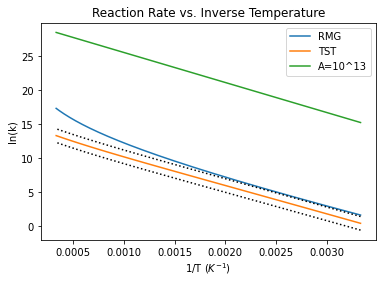

In [52]:
%matplotlib inline
# Make the Arrhenius plot using RMG
print(ref_database.libraries[ref_lib].entries[key].label)
ref_database.libraries[ref_lib].entries[key].data

plt.xlabel('1/T ($K^{-1})$')
plt.ylabel('ln(k)')
plt.title('Reaction Rate vs. Inverse Temperature')
T_ = np.linspace(300, 3000, 1001)
T_inv = 1.0 / T_

k_rmg = np.zeros(len(T_))
k_exp = np.zeros(len(T_))
for i in range(0, len(T_)):
    k_rmg[i] = rmg_kinetics.get_rate_coefficient(T_[i])
#     k_exp[i] = exp_kinetics.get_rate_coefficient(T_[i])
plt.plot(T_inv, np.log(k_rmg), 1.0 / T, np.log(k_TST), 1.0 / T, np.log(k_primitive))
plt.plot(1.0 / T, np.log(k_TST) + 1.0, 1.0 / T, np.log(k_TST) - 1.0, color='black', linestyle=':')
# plt.plot( T, np.log(k_TST))
plt.legend(['RMG', 'TST', 'A=10^13'])

In [53]:
# I thought TST was supposed to strictly overestimate the rate...